## Notebook to plot Aitchison Distance versus Read Length

In [6]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [7]:
reads_df = pd.read_csv('../../paper/read_stats.csv', encoding='utf-8')
reads_df.set_index("Community", inplace=True)
reads_recode = {
    "sub_bmock12": "S1_bmock12",
    "amos_hilo": "hilo",
    "amos_mixed": "mixed",
    "S1_camisim": "S1_camisimGI",
    "S2_camisim": "S2_camisimGI",
    "Mix-A_nist": "MIX-A_nist",
    "Mix-B_nist": "MIX-B_nist",
    "Mix-C_nist": "MIX-C_nist",
    "Mix-D_nist": "MIX-D_nist",
}

reads_df = reads_df.rename(reads_recode)
display(reads_df)

,num_seqs,sum_len,min_len,avg_len,max_len
Community,,,,,
S1_bmock12,100500000.00 +- 0.00,15175500000.00 +- 0.00,151.00 +- 0.00,151.00 +- 0.00,151.00 +- 0.00
S1_camisimGI,16666158.00 +- 0.00,2473504212.50 +- 12668039.31,31.00 +- 0.00,148.45 +- 0.78,150.00 +- 0.00
S2_camisimGI,16666291.00 +- 0.00,2473723888.00 +- 12664634.59,31.00 +- 0.00,148.45 +- 0.78,150.00 +- 0.00
EG_nist,3353278.00 +- 0.00,282025983.00 +- 3833426.68,15.00 +- 0.00,84.10 +- 1.13,151.00 +- 0.00
MIX-A_nist,3473553.00 +- 0.00,365925482.50 +- 2529868.96,19.00 +- 5.66,105.35 +- 0.78,151.00 +- 0.00
MIX-B_nist,3583192.00 +- 0.00,376371686.50 +- 2769876.56,18.50 +- 4.95,105.05 +- 0.78,151.00 +- 0.00
MIX-C_nist,2974354.00 +- 0.00,325816856.00 +- 2268975.55,16.50 +- 2.12,109.55 +- 0.78,151.00 +- 0.00
MIX-D_nist,3278203.00 +- 0.00,373347674.50 +- 2103394.48,20.00 +- 7.07,113.85 +- 0.64,151.00 +- 0.00
tourlousse,5897627.83 +- 378678.85,855639825.08 +- 51884672.55,15.00 +- 0.00,145.12 +- 1.31,151.00 +- 0.00


In [8]:
def make_joined(df_left: pd.DataFrame, df_right: pd.DataFrame):
    joined = pd.merge(df_left, df_right, how="left", left_on="combined_name", right_index=True)

    cols = joined.columns.to_list()[13:]

    for c in cols:
        joined = split_cols(joined, c, sep = "+-")

    return joined


def split_cols(df: pd.DataFrame, col: str, sep: str = ','):
    """Split a column into multiple columns"""
    df = df.copy()
    # display(df)
    df[[col, f'{col}_stddev']] = df[col].str.split(re.escape(sep), expand=True)
    # df = df.explode(col)
    # display(df)
    return df

In [9]:
combined_df = pd.DataFrame()

stats_df = pd.read_csv("../results/all_stats_species_2023-03-13.csv")
stats_df["combined_name"] = stats_df["SampleID"] + "_" + stats_df["Source"]

# We only want thresholds == 0.0001
stats_df = stats_df[stats_df["threshold"] == 0.0001]
stats_df = stats_df[stats_df["Pipeline"] != "jams202212"]

for t, t_df in stats_df.groupby("threshold"):
    for pl, pl_df in t_df.groupby("Pipeline"):
        for src, src_df in pl_df.groupby("Source"):
            # print(src)
            if src == "hilo" or src == "mixed" or src == "tourlousse":
                src_df.loc['mean'] = src_df.mean(numeric_only=True, axis=0)
                mean = src_df.loc[['mean']].copy()
                mean["Source"] = src
                mean["Pipeline"] = pl
                mean["combined_name"] = src
                # display(mean.head())
                joined = make_joined(mean, reads_df)
                
                combined_df = pd.concat([combined_df, joined])
            else:
                # display(src_df.head())
                joined = make_joined(src_df, reads_df)

                combined_df = pd.concat([combined_df, joined])
            
combined_df.to_csv("stats_reads_combined.csv", index=False)

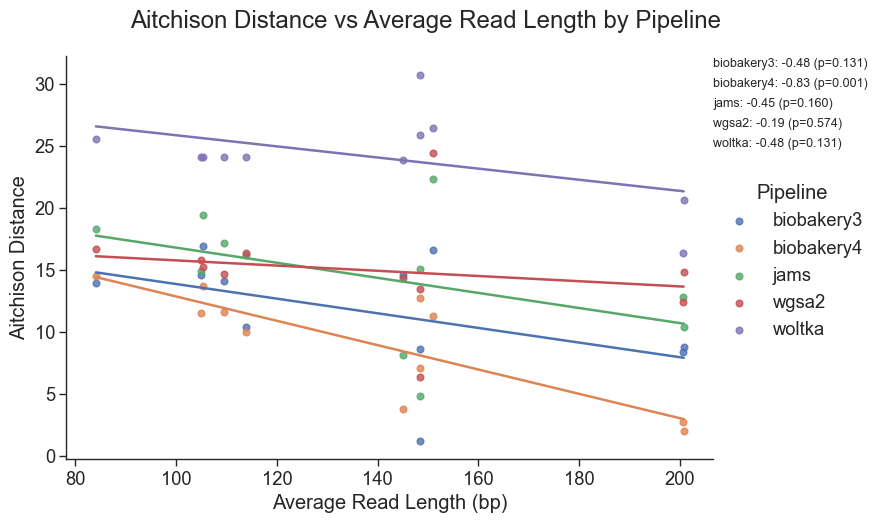

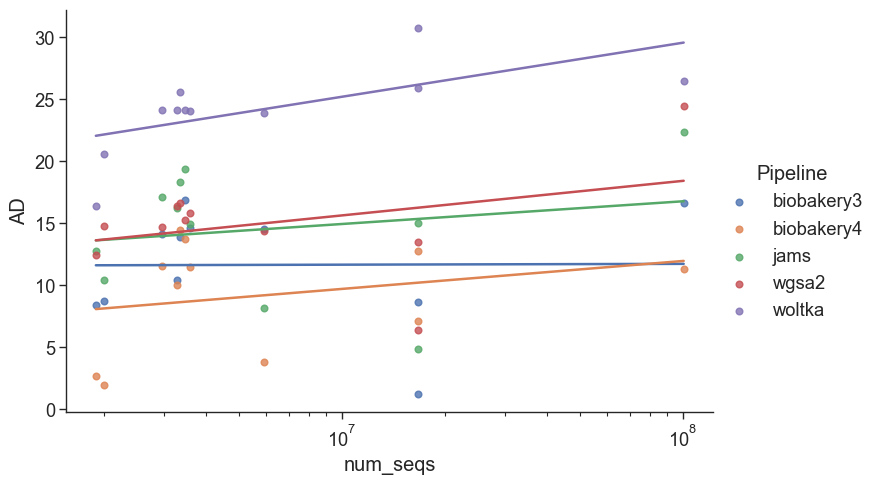

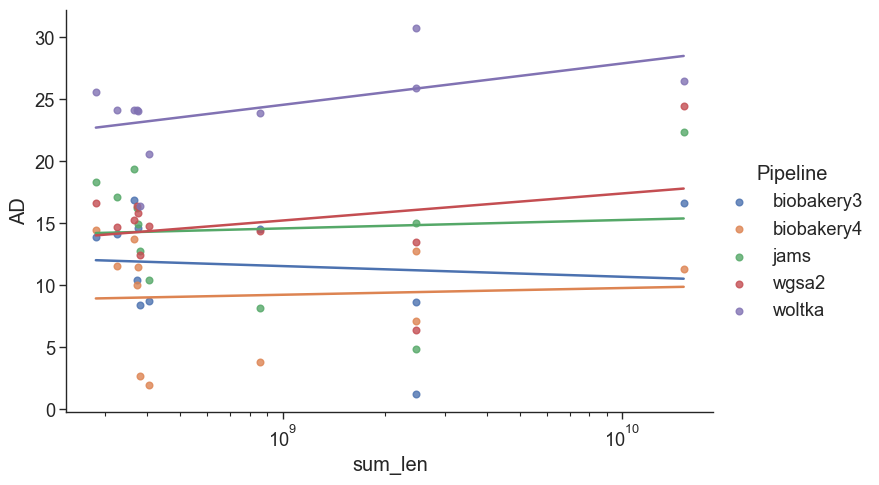

In [10]:
combined_df = combined_df.astype({"AD": float, "avg_len": float, "num_seqs": float, "sum_len": float})

def decorate_sns():
    # Make a scatterplot of AD vs avg_len
    sns.set_theme(style="whitegrid")
    sns.set_context("paper", font_scale=1.5)
    sns.set_style("ticks")

def pearson_df(df: pd.DataFrame, x: str):
    """
    Do a pearson correlation test on a dataframe between a column (argument x) and AD on the input dataframe, df.
    Parameters:
        df: pd.DataFrame
            The dataframe to perform the test on
        x: str
            The column to perform the test on
    Returns:
        pearson_df: pd.DataFrame
            A dataframe with the pearson correlation coefficient and p-value for each pipeline.
    """
    pearson_df = pd.DataFrame()
    for pl, pl_df in df.groupby("Pipeline"):
        coeff, p = pearsonr(pl_df[x], pl_df['AD'])
        row = {"Pipeline": pl, "Pearson": coeff, "p": p}
        pearson_df = pd.concat([pearson_df, pd.DataFrame(row, index=[0])])
 
    return pearson_df


# Use avg_len, num_seqs, sum_len
def make_plots():
    x_labels = ["avg_len", "num_seqs", "sum_len"]
    for x in x_labels:
        if x == "avg_len":
            g = sns.lmplot(data=combined_df, x=x, y="AD", hue="Pipeline", height=5, aspect=1.5, ci=None, fit_reg=True)

            p_df = pearson_df(combined_df, x)

            # Since the pandas people deprecated the old way of doing this, we have to do it this way.
            p_df.style.hide(axis="index").to_latex("pearson_avg_len.tex")

            g.fig.suptitle("Aitchison Distance vs Average Read Length by Pipeline", y=1.05)
            g.set_ylabels("Aitchison Distance")
            g.set_xlabels("Average Read Length (bp)")

            # Now, add the pearson correlation coefficient and p-value to the plot
            for c, (i, row) in enumerate(p_df.iterrows()):
                # p_val = f"{row['p']:.3f}" if row['p'] < 0.05 else "ns"
                p_val = f"{row['p']:.3f}"
                g.ax.text(1.0, 0.975 - (c * 0.05), f"{row['Pipeline']}: {row['Pearson']:.2f} (p={p_val})", transform=g.ax.transAxes, fontsize=9)

            g.fig.savefig("ad_vs_readlength.pdf", bbox_inches='tight', dpi=300)
                        
        else:
            g = sns.lmplot(data=combined_df, x=x, y="AD", hue="Pipeline", height=5, aspect=1.5, ci=None, fit_reg=True, logx=True)
            g.set(xscale="log")

        plt.show()

decorate_sns()
make_plots()